# Dependencies and setup

In [83]:
import cv2
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, metrics, model_selection

from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout

np.random.seed(2019)
data_dir = os.path.join('..', 'Data', 'Training')

# Read all the data into memory

In [131]:
# Get a list of all the data files
data_files = glob.glob(os.path.join(data_dir, '*.png'))

# Read the first image to get the size
test_img = cv2.imread(data_files[0])
img_size = test_img.shape[0:2]

# Initialize data elements (avoids resizing later)
X = np.zeros((len(data_files), img_size[0], img_size[1]))
y = np.zeros(len(data_files))

# Step through all the files
current_idx = 0;
for fs in data_files:
    # Parse the filename (we only really care about extracting the object class)
    x = re.search("\d+\.\d+\.(\S+)\.png", fs)
    
    # Read the file
    img = cv2.imread(fs)
    img = np.squeeze(img[:,:,1]) # select the first color channel
    
    if (x.group(1) == '1'): # "Car"
        X[current_idx,:,:] = img
        y[current_idx] = 1
        current_idx += 1
    elif(x.group(1) == 'bg'): # Background
        X[current_idx,:,:] = img
        y[current_idx] = 0
        current_idx += 1

num_cars = np.count_nonzero(y==1)
num_bg = np.count_nonzero(y==0)
print("found {} cars and {} background images".format(num_cars, num_bg))

# Equalize the class probabilities for training (delete a random subset)
# We do this now and not earlier because we don't know fully what we are going to get out of the directory apriori
num_bg_to_delete = np.round(0).astype('int')
if (num_bg_to_delete):
    print("Deleting ", num_bg_to_delete, " background images")
    bg_idx = np.nonzero(y==0)[0]
    np.random.shuffle(bg_idx)
    to_delete = bg_idx[0:num_bg_to_delete]
    y = np.delete(y,to_delete)
    X = np.delete(X,to_delete, axis=0)
    
num_cars = np.count_nonzero(y==1)
num_bg = np.count_nonzero(y==0)
print("After class equalization, there are {} cars and {} background images".format(num_cars, num_bg))
print(X.shape)

found 852 cars and 5014 background images
After class equalization, there are 852 cars and 5014 background images
(5866, 64, 64)


<function matplotlib.pyplot.show(*args, **kw)>

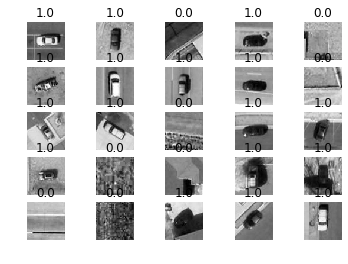

In [85]:
imgs_to_show = 25
imgs_per_col = 5
for i in range(0, imgs_to_show):
    plt.subplot(imgs_to_show/imgs_per_col, imgs_per_col, i+1)
    plt.imshow(X[i,:,:], cmap='gray')
    plt.axis('off')
    plt.title(y[i])
plt.show

# Classification setup

0.88235295
0.4862745


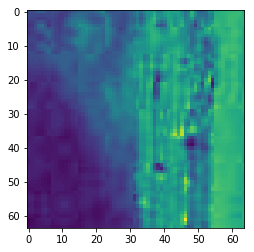

In [132]:
X_float = X.astype('float32')
X_float /= 255

print(X_float[0,:,:].max())
print(X_float[0,:,:].min())
plt.imshow(X_float[0,:,:])
plt.show()

# SVM Classifier

In [166]:
X_flat = X.reshape((len(X), -1))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_flat, y, test_size=0.25, random_state=23)

In [167]:
parameters = [
    {'kernel':['rbf'], 'gamma':np.logspace(-8, -5, 10)}
]
clf=svm.SVC(probability=True)
cv_clf=model_selection.GridSearchCV(estimator=clf, param_grid=parameters, cv=4, n_jobs=-1);
cv_clf.fit(X_train,y_train)
print("Best estimator:\n", cv_clf.best_estimator_)

#Check performance
y_pred = cv_clf.predict(X_test)

print("Accuracy score:\n", metrics.accuracy_score(y_test,y_pred))

Best estimator:
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-07, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy score:
 0.9686434901158828


In [168]:
print(y_pred[0:30])

[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0.]


# CNN

(5866, 64, 64)
(64, 64, 1)


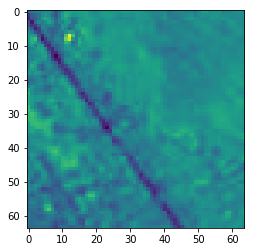

In [133]:
X_for_cnn = X_float
print(X_for_cnn.shape)
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_for_cnn.reshape(X_for_cnn.shape[0], X_for_cnn.shape[1], X_for_cnn.shape[2], 1), y, test_size=0.20, random_state=23)
input_shape = (x_train.shape[1], x_train.shape[2], 1)
print(input_shape)

plt.imshow(x_train[0,:,:,0])
plt.show()

In [134]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=input_shape))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(filters=32, kernel_size=(4,4)))
cnn_model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(2,activation='softmax'))
cnn_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
cnn_model.fit(x=x_train,y=y_train, epochs=10)

Epoch 1/10
4692/4692 [==============================] - 13s 3ms/sample - loss: 0.3483 - acc: 0.8651
Epoch 2/10
4692/4692 [==============================] - 12s 3ms/sample - loss: 0.1198 - acc: 0.9535
Epoch 3/10
4692/4692 [==============================] - 12s 3ms/sample - loss: 0.0934 - acc: 0.9665
Epoch 4/10
4692/4692 [==============================] - 13s 3ms/sample - loss: 0.0863 - acc: 0.9693
Epoch 5/10
4692/4692 [==============================] - 13s 3ms/sample - loss: 0.0965 - acc: 0.9659
Epoch 6/10
4692/4692 [==============================] - 13s 3ms/sample - loss: 0.0577 - acc: 0.9793
Epoch 7/10
4692/4692 [==============================] - 13s 3ms/sample - loss: 0.0637 - acc: 0.9761
Epoch 8/10
4692/4692 [==============================] - 13s 3ms/sample - loss: 0.0489 - acc: 0.9806
Epoch 9/10
4692/4692 [==============================] - 13s 3ms/sample - loss: 0.0438 - acc: 0.9832
Epoch 10/10
4692/4692 [==============================] - 13s 3ms/sample - loss: 0.0416 - acc: 0.9836

The precision/recall plotting was taken from the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

Test loss: 0.055004485459201787
Test accuracy: 0.9795571
(1174,)
[1.4903242e-09 1.4903242e-09 8.9572459e-01 1.3216962e-02 2.1383471e-06
 4.4880153e-04 9.7815460e-01 8.2335272e-04 3.9503269e-05]
[0. 0. 1. 0. 0. 0. 1. 0. 0.]


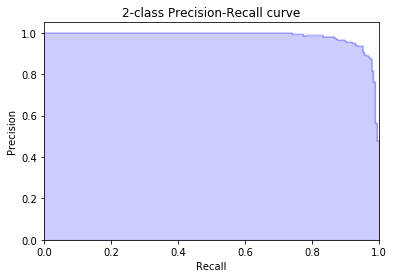

In [135]:
score = cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_test_hat = cnn_model.predict(x_test)[:,1]
print(y_test_hat.shape)
print(y_test_hat[1:10])
print(y_test[1:10])
precision, recall, _ = metrics.precision_recall_curve(y_test, y_test_hat)
step_kwargs = {'step': 'post'}
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve');

Guessed  1  was  0.0  probs [2.4169509e-04 9.9975830e-01]


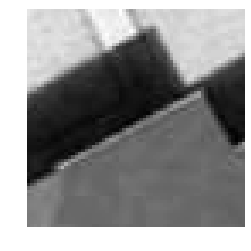

Guessed  0  was  1.0  probs [0.64667714 0.3533228 ]


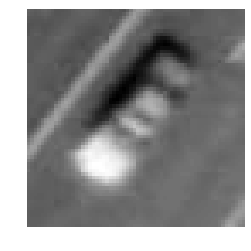

Guessed  1  was  0.0  probs [4.716768e-04 9.995283e-01]


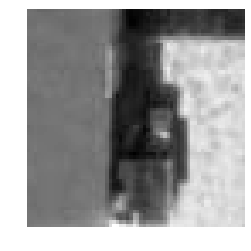

Guessed  1  was  0.0  probs [0.03146974 0.96853024]


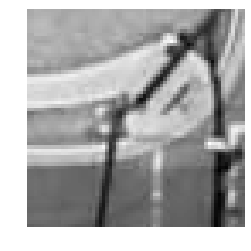

Guessed  1  was  0.0  probs [0.27582774 0.72417235]


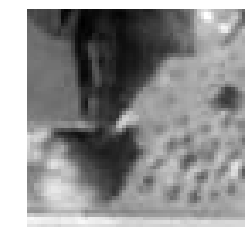

Guessed  0  was  1.0  probs [0.9934772 0.0065228]


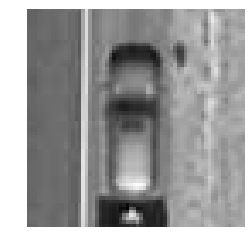

Guessed  0  was  1.0  probs [0.5368879  0.46311212]


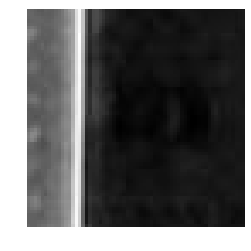

Guessed  0  was  1.0  probs [0.70901734 0.2909827 ]


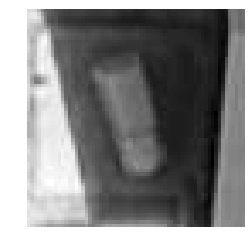

Guessed  1  was  0.0  probs [0.06399882 0.9360012 ]


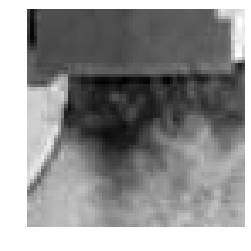

Guessed  0  was  1.0  probs [0.9072821  0.09271785]


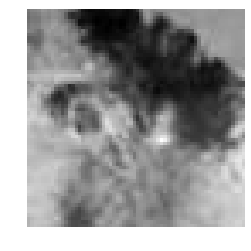

Guessed  0  was  1.0  probs [0.9982652  0.00173486]


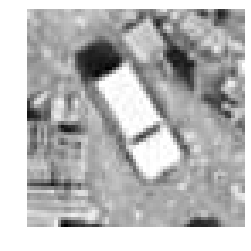

Guessed  1  was  0.0  probs [0.04120922 0.9587908 ]


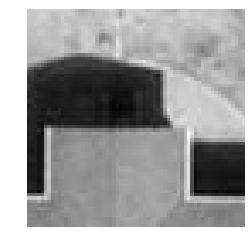

Guessed  1  was  0.0  probs [0.17552772 0.82447225]


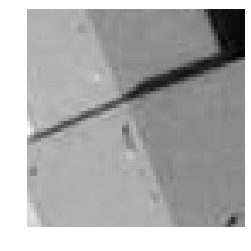

Guessed  1  was  0.0  probs [0.0168318 0.9831682]


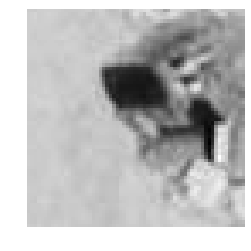

Guessed  0  was  1.0  probs [0.52383417 0.47616583]


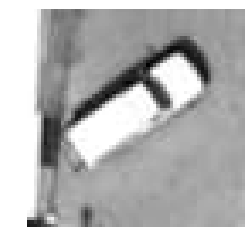

Guessed  0  was  1.0  probs [0.9986627 0.0013373]


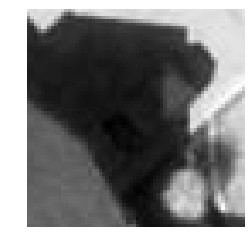

In [127]:
y_hat = cnn_model.predict(x_test)
for i in range(0, len(y_test)):
    if np.argmax(y_hat[i,:]) != y_test[i]:
        print("Guessed ", np.argmax(y_hat[i,:]), " was ", y_test[i], " probs", y_hat[i,:])
        plt.imshow(np.squeeze(x_test[i,:,:,:]), cmap='gray');
        plt.axis('off')
        plt.show()

# Transfer learning from ResNet50
[Kaggle Example](https://www.kaggle.com/dansbecker/transfer-learning)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.float64'>
(5866, 64, 64, 3)


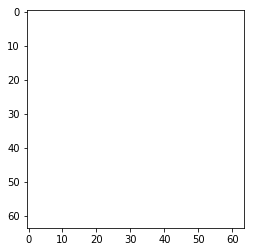

In [155]:
X_color = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X_color = np.tile(X_color, (1,1,1,3))
X_color /= 3
print(type(X_color[0,0,0,0]))
print(X_color.shape)
plt.imshow(X_color[0,:,:,:])
plt.show()
                  
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_color, y, test_size=0.25, random_state=23)
input_shape = (x_train.shape[1], x_train.shape[2], 3)

In [143]:
transfer_model = Sequential()
transfer_model.add(ResNet50(include_top=False, input_shape=input_shape, pooling='avg', weights='imagenet'))
transfer_model.add(Dense(2,activation='softmax'))
transfer_model.layers[0].trainable = False

In [144]:
transfer_model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
transfer_model.fit(x=x_train,y=y_train, epochs=3)

Epoch 1/3
4399/4399 [==============================] - 33s 7ms/sample - loss: 0.2026 - acc: 0.9495
Epoch 2/3
4399/4399 [==============================] - 36s 8ms/sample - loss: 0.1029 - acc: 0.9709
Epoch 3/3
4399/4399 [==============================] - 36s 8ms/sample - loss: 0.0913 - acc: 0.9752


In [145]:
score = transfer_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20716913727041647
Test accuracy: 0.94955695


# Run a classifier on a full image

<class 'numpy.uint8'>


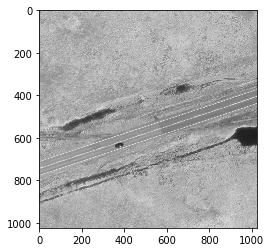

In [160]:
from segmentation import run_sliding_window

img_dir = os.path.join('..', 'Data', 'Vehicules1024')

test_img = cv2.imread(os.path.join(img_dir, "00000014_ir.png" ))
print(type(test_img[0,0,0]))
plt.imshow(test_img)
plt.show()

In [161]:
partitioned_image = run_sliding_window(test_img, 8, 64, 64)
partitioned_image_one_ch = partitioned_image[:,:,:,:,0]
partitioned_image_flat = partitioned_image_one_ch.reshape((-1, 64, 64, 1))

partitioned_image_for_svm = partitioned_image_flat.reshape((-1, 64*64))

partitioned_image_for_cnn = partitioned_image_flat.astype('float32')
partitioned_image_for_cnn /= 255

partitioned_image_for_transfer = np.tile(partitioned_image_flat.astype('float64'), (1,1,1,3))
partitioned_image_for_transfer /= 3

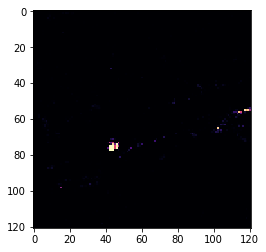

In [165]:
#class_flat = cv_clf.predict(partitioned_image_for_svm)
#class_flat = cnn_model.predict(partitioned_image_for_cnn)[:,1]
class_flat = transfer_model.predict(partitioned_image_for_transfer)[:,1]
class_img = class_flat.reshape((partitioned_image_one_ch.shape[0], partitioned_image_one_ch.shape[1]))
plt.imshow(class_img, cmap='magma')
plt.show()

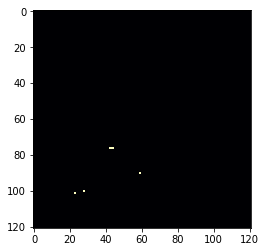

In [164]:
class_img_thresh = class_img>0.9
plt.imshow(class_img_thresh, cmap='magma')
plt.show()